In [12]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import f, norm, pearsonr, ttest_rel

# Load data
study_name = "Affective Primes"
specification_name = "default persona"
human_file = f"{study_name} human data values anonymized.csv"
twin_file = f"{study_name} twins data values anonymized.csv"
df_human = pd.read_csv(human_file, header=0, skiprows=[1, 2])
df_twin = pd.read_csv(twin_file, header=0, skiprows=[1, 2])


# add new columns with relevant variables coded
# create composite measures in both human and twin dfs
for df in (df_human, df_twin):
    # Gratitude manipulation check: average of g_manip_check_1–3
    df["gratitude_manipulation_check"] = df[
        ["g_manip_check_1", "g_manip_check_2", "g_manip_check_3"]
    ].mean(axis=1)

    # Elevation scale: average of elevation_1–6
    df["elevation_scale"] = df[[f"elevation_{i}" for i in range(1, 7)]].mean(axis=1)

    # Empathic concern measure: average of DV1_1 and DV1_2
    df["empathic_concern_measure"] = df[["DV1_1", "DV1_2"]].mean(axis=1)

    # Lack of control manipulation check: average of c_manip_check_1–3
    df["lack_of_control_manipulation_check"] = df[
        ["c_manip_check_1", "c_manip_check_2", "c_manip_check_3"]
    ].mean(axis=1)

    # Fatigue scale: reverse‐code items 3, 7, and 8 (8 – value), then average
    fat_items = [f"fatigue_{i}" for i in range(1, 10)]
    fat_rev = df[fat_items].copy()
    for i in (3, 7, 8):
        fat_rev[f"fatigue_{i}"] = 8 - fat_rev[f"fatigue_{i}"]
    df["fatigue_scale"] = fat_rev.mean(axis=1)

    # Desire for predictability measure: reverse‐code items 1, 4, and 5, then average 1–8
    desire_items = [f"desire_predict_{i}" for i in range(1, 9)]
    desire_rev = df[desire_items].copy()
    for i in (1, 4, 5):
        desire_rev[f"desire_predict_{i}"] = 8 - desire_rev[f"desire_predict_{i}"]
    df["desire_for_predictability_measure"] = desire_rev.mean(axis=1)

for df in (df_human, df_twin):
    # Overall gratitude = mean of elevation_scale and empathic_concern_measure
    df["gratitude"] = df[["elevation_scale", "empathic_concern_measure"]].mean(axis=1)

    # Overall lack of control = mean of fatigue_scale and desire_for_predictability_measure
    df["lack of control"] = df[["fatigue_scale", "desire_for_predictability_measure"]].mean(axis=1)


out_file = f"{study_name} {specification_name} human data processed.csv"
df_human.to_csv(out_file, index=False)
out_file = f"{study_name} {specification_name} twins data processed.csv"
df_twin.to_csv(out_file, index=False)


# define relevant columns:
# condition variable names:
condition_vars = ["cond"]
# Check if we have a real condition var
if condition_vars and condition_vars[0].strip():
    cond = condition_vars[0]
    cond_h = f"{cond}_human"
    cond_t = f"{cond}_twin"
    cond_exists = True
else:
    cond_exists = False

# raw responses:
raw_vars = []
# raw_vars_min = []
# raw_vars_max = []
# #raw responses: domain=social?
# raw_vars_social=[]
# raw_vars_social_map = dict(zip(raw_vars, raw_vars_social))
# #raw responses: domain=cognitive?
# raw_vars_cognitive=[]
# raw_vars_cognitive_map = dict(zip(raw_vars, raw_vars_cognitive))
# #raw responses: replicating know human bias?
# raw_vars_known=[]
# raw_vars_known_map = dict(zip(raw_vars, raw_vars_known))
# #raw responses: preference measure?
# raw_vars_pref=[]
# raw_vars_pref_map = dict(zip(raw_vars, raw_vars_pref))
# #raw responses: stimuli dependent?
# raw_vars_stim=[]
# raw_vars_stim_map = dict(zip(raw_vars, raw_vars_stim))

# DVs:
DV_vars = [
    "gratitude",
    "lack of control",
    "gratitude_manipulation_check",
    "lack_of_control_manipulation_check",
]
DV_vars_min = [1, 1, 1, 1]
DV_vars_max = [7, 7, 7, 7]
# DVs: domain=social?
DV_vars_social = [1] * 4
DV_vars_social_map = dict(zip(DV_vars, DV_vars_social))
# DVs: domain=cognitive?
DV_vars_cognitive = [0] * 4
DV_vars_cognitive_map = dict(zip(DV_vars, DV_vars_cognitive))
# DVs: replicating know human bias?
DV_vars_known = [0] * 4
DV_vars_known_map = dict(zip(DV_vars, DV_vars_known))
# DVs: preference measure?
DV_vars_pref = [0] * 4
DV_vars_pref_map = dict(zip(DV_vars, DV_vars_pref))
# DVs: stimuli dependent?
DV_vars_stim = [1] * 4
DV_vars_stim_map = dict(zip(DV_vars, DV_vars_stim))
# DVs: knowledge question?
DV_vars_know = [0] * 4
DV_vars_know_map = dict(zip(DV_vars, DV_vars_know))
# DVs: political question?
DV_vars_politics = [0] * 4
DV_vars_politics_map = dict(zip(DV_vars, DV_vars_politics))


# merging key
merge_key = ["TWIN_ID"]

# Merge on TWIN_ID
df = pd.merge(df_human, df_twin, on=merge_key, suffixes=("_human", "_twin"))

# Fix dtypes
for var in DV_vars:
    df[f"{var}_human"] = pd.to_numeric(df[f"{var}_human"], errors="coerce")
    df[f"{var}_twin"] = pd.to_numeric(df[f"{var}_twin"], errors="coerce")

# build min/max maps from both raw_vars and DV_vars
min_map = {v: mn for v, mn in zip(DV_vars, DV_vars_min)}
# min_map = {v: mn for v, mn in zip(raw_vars,      raw_vars_min)}
# min_map.update({v: mn for v, mn in zip(DV_vars,   DV_vars_min)})

max_map = {v: mx for v, mx in zip(DV_vars, DV_vars_max)}
# max_map = {v: mx for v, mx in zip(raw_vars,      raw_vars_max)}
# max_map.update({v: mx for v, mx in zip(DV_vars,   DV_vars_max)})

# now add _min and _max columns for every variable in the union
for var in min_map:
    df[f"{var}_min"] = min_map[var]
    df[f"{var}_max"] = max_map[var]

# Compute results
results = []
# for var in raw_vars:
#     ##############################
#     #07/18/26: condition assignment different for each DV.
# #     col_h = f"{var}_human"
# #     col_t = f"{var}_twin"
# #     min_col = f"{var}_min"
# #     max_col = f"{var}_max"
# #     if cond_exists:
# #         cols = [col_h, col_t, cond_h, cond_t,min_col,max_col]
# #     else:
# #         cols = [col_h, col_t,min_col,max_col]
# #     pair = (
# #     df[cols]
# #       .dropna(subset=[col_h, col_t])
# #     )
# # look up the right condition for this DV
#     cond    = dv_to_cond[var]           # e.g. 'condition_green'
#     cond_h  = f"{cond}_human"           # 'condition_green_human'
#     cond_t  = f"{cond}_twin"            # 'condition_green_twin'
#     col_h   = f"{var}_human"
#     col_t   = f"{var}_twin"
#     min_col = f"{var}_min"
#     max_col = f"{var}_max"
#     # always include the matching condition columns
#     cols = [col_h, col_t, cond_h, cond_t, min_col, max_col]
#     pair = df[cols].dropna(subset=[col_h, col_t, cond_h, cond_t])
# ####################################

#     min_val = pair[min_col].iloc[0]
#     max_val = pair[max_col].iloc[0]
#     n    = len(pair)
#     if n >= 4:
#         r, _    = pearsonr(pair[col_h], pair[col_t])
#         z_f     = np.arctanh(r)
#         se      = 1 / np.sqrt(n - 3)
#         z_crit  = norm.ppf(0.975)
#         lo_z, hi_z = z_f - z_crit*se, z_f + z_crit*se
#         lo_r, hi_r = np.tanh(lo_z), np.tanh(hi_z)
#         z_score    = z_f / se
#         # Accuracy = mean absolute diff / range
#         if pd.isna(min_val) or pd.isna(max_val) or max_val == min_val:
#             accuracy = np.nan
#         else:
#             # compute mean absolute difference
#             abs_diff      = np.abs(pair[col_h] - pair[col_t])
#             mean_abs_diff = abs_diff.mean()
#             accuracy      = 1 - mean_abs_diff / (max_val - min_val)

#         mean_h = pair[col_h].mean()
#         mean_t = pair[col_t].mean()

#         # Paired t‐test
#         t_stat, p_val = ttest_rel(pair[col_h], pair[col_t])

#         std_h = pair[col_h].std(ddof=1)
#         std_t = pair[col_t].std(ddof=1)

#          # F‐test for equal variances
#         df1 = df2 = n - 1
#         f_stat = (std_h**2 / std_t**2) if std_t>0 else np.nan

#         # two‐tailed p‐value:
#         if not np.isnan(f_stat):
#             p_f = 2 * min(f.cdf(f_stat, df1, df2),
#                           1 - f.cdf(f_stat, df1, df2))
#         else:
#             p_f = np.nan

#         # Effect sizes (Cohen's d) across conditions
#         #    For humans:
#         if cond_exists and len(pair)>3:
#             levels_h = pair[cond_h].unique()
#             if len(levels_h) == 2:
#                 g1 = pair.loc[pair[cond_h]==levels_h[0], col_h]
#                 g2 = pair.loc[pair[cond_h]==levels_h[1], col_h]
#                 n1, n2 = len(g1), len(g2)
#                 # pooled sd
#                 s_pool = np.sqrt(((n1-1)*g1.var(ddof=1)+(n2-1)*g2.var(ddof=1)) / (n1+n2-2))
#                 d_human = (g1.mean() - g2.mean()) / s_pool if s_pool>0 else np.nan
#             else:
#                 d_human = np.nan
#         else:
#             d_human = np.nan

#         #    For twins:
#         if cond_exists and len(pair)>3:
#             levels_t = pair[cond_t].unique()
#             if cond_exists and len(levels_t) == 2:
#                 g1 = pair.loc[pair[cond_t]==levels_t[0], col_t]
#                 g2 = pair.loc[pair[cond_t]==levels_t[1], col_t]
#                 n1, n2 = len(g1), len(g2)
#                 s_pool = np.sqrt(((n1-1)*g1.var(ddof=1)+(n2-1)*g2.var(ddof=1)) / (n1+n2-2))
#                 d_twin = (g1.mean() - g2.mean()) / s_pool if s_pool>0 else np.nan
#             else:
#                 d_twin = np.nan
#         else:
#             d_twin = np.nan
#     else:
#         r = lo_r = hi_r = z_score = accuracy = mean_h = mean_t = t_stat = p_val = std_h = std_t = f_stat = p_f = np.nan
#         d_human = d_twin = np.nan


#     results.append({
#         'study name': study_name,
#         'variable name': var,
#         'variable type (raw response/DV)':     'raw',
#         'correlation between the responses from humans vs. their twins':        r,
#         'CI_lower': lo_r,
#         'CI_upper': hi_r,
#         'z-score for correlation between humans vs. their twins':  z_score,
#         'accuracy between humans vs. their twins': accuracy,
#         'mean_human': mean_h,
#         'mean_twin': mean_t,
#         'paired t-test t-stat': t_stat,
#         'paired t-test p-value': p_val,
#         'std_human': std_h,
#         'std_twin': std_t,
#         'variance test F-stat': f_stat,
#         'variance test p-value': p_f,
#         'effect size based on human': d_human,
#         'effect size based on twin': d_twin,
#         'domain=social?':raw_vars_social_map.get(var, np.nan),
#         'domain=cognitive?':raw_vars_cognitive_map.get(var, np.nan),
#         'replicating know human bias?':raw_vars_known_map.get(var, np.nan),
#         'preference measure?':raw_vars_pref_map.get(var, np.nan),
#         'stimuli dependent?':raw_vars_stim_map.get(var, np.nan),
#         'sample size':        n
#     })

for var in DV_vars:
    col_h = f"{var}_human"
    col_t = f"{var}_twin"
    min_col = f"{var}_min"
    max_col = f"{var}_max"

    if cond_exists:
        cols = [col_h, col_t, cond_h, cond_t, min_col, max_col]
    else:
        cols = [col_h, col_t, min_col, max_col]

    dropped_ids = df.loc[df[col_h].isna() | df[col_t].isna(), "TWIN_ID"].unique()
    if len(dropped_ids):
        print(f"{var}: dropping {len(dropped_ids)} pairs → TWIN_IDs: {dropped_ids.tolist()}")
    else:
        print(f"{var}: no observation dropped ")

    pair = df[cols].dropna(subset=[col_h, col_t])
    min_val = pair[min_col].iloc[0]
    max_val = pair[max_col].iloc[0]
    n = len(pair)
    if n >= 4:
        r, _ = pearsonr(pair[col_h], pair[col_t])
        z_f = np.arctanh(r)
        se = 1 / np.sqrt(n - 3)
        z_crit = norm.ppf(0.975)
        lo_z, hi_z = z_f - z_crit * se, z_f + z_crit * se
        lo_r, hi_r = np.tanh(lo_z), np.tanh(hi_z)
        z_score = z_f / se
        # Accuracy = mean absolute diff / range
        if pd.isna(min_val) or pd.isna(max_val) or max_val == min_val:
            accuracy = np.nan
        else:
            # compute mean absolute difference
            abs_diff = np.abs(pair[col_h] - pair[col_t])
            mean_abs_diff = abs_diff.mean()
            accuracy = 1 - mean_abs_diff / (max_val - min_val)

        mean_h = pair[col_h].mean()
        mean_t = pair[col_t].mean()

        # Paired t‐test
        t_stat, p_val = ttest_rel(pair[col_h], pair[col_t])

        std_h = pair[col_h].std(ddof=1)
        std_t = pair[col_t].std(ddof=1)

        # F‐test for equal variances
        df1 = df2 = n - 1
        f_stat = (std_h**2 / std_t**2) if std_t > 0 else np.nan
        # two‐tailed p‐value:
        if not np.isnan(f_stat):
            p_f = 2 * min(f.cdf(f_stat, df1, df2), 1 - f.cdf(f_stat, df1, df2))
        else:
            p_f = np.nan

        # Effect sizes (Cohen's d) across conditions
        #    For humans:
        if cond_exists and len(pair) > 3:
            levels_h = pair[cond_h].unique()
            if len(levels_h) == 2:
                g1 = pair.loc[pair[cond_h] == levels_h[0], col_h]
                g2 = pair.loc[pair[cond_h] == levels_h[1], col_h]
                n1, n2 = len(g1), len(g2)
                # pooled sd
                s_pool = np.sqrt(
                    ((n1 - 1) * g1.var(ddof=1) + (n2 - 1) * g2.var(ddof=1)) / (n1 + n2 - 2)
                )
                d_human = (g1.mean() - g2.mean()) / s_pool if s_pool > 0 else np.nan
            else:
                d_human = np.nan
        else:
            d_human = np.nan

        #    For twins:
        if cond_exists and len(pair) > 3:
            levels_t = pair[cond_t].unique()
            if cond_exists and len(levels_t) == 2:
                g1 = pair.loc[pair[cond_t] == levels_t[0], col_t]
                g2 = pair.loc[pair[cond_t] == levels_t[1], col_t]
                n1, n2 = len(g1), len(g2)
                s_pool = np.sqrt(
                    ((n1 - 1) * g1.var(ddof=1) + (n2 - 1) * g2.var(ddof=1)) / (n1 + n2 - 2)
                )
                d_twin = (g1.mean() - g2.mean()) / s_pool if s_pool > 0 else np.nan
            else:
                d_twin = np.nan
        else:
            d_twin = np.nan
    else:
        r = lo_r = hi_r = z_score = accuracy = mean_h = mean_t = t_stat = p_val = std_h = std_t = (
            f_stat
        ) = p_f = np.nan
        d_human = d_twin = np.nan

    results.append(
        {
            "study name": study_name,
            "persona specification": specification_name,
            "variable name": var,
            #        'variable type (raw response/DV)':     'DV',
            "correlation between the responses from humans vs. their twins": r,
            "CI_lower": lo_r,
            "CI_upper": hi_r,
            "z-score for correlation between humans vs. their twins": z_score,
            "accuracy between humans vs. their twins": accuracy,
            "mean_human": mean_h,
            "mean_twin": mean_t,
            "paired t-test t-stat": t_stat,
            "paired t-test p-value": p_val,
            "std_human": std_h,
            "std_twin": std_t,
            "variance test F-stat": f_stat,
            "variance test p-value": p_f,
            "effect size based on human": d_human,
            "effect size based on twin": d_twin,
            "domain=social?": DV_vars_social_map.get(var, np.nan),
            "domain=cognitive?": DV_vars_cognitive_map.get(var, np.nan),
            "replicating know human bias?": DV_vars_known_map.get(var, np.nan),
            "preference measure?": DV_vars_pref_map.get(var, np.nan),
            "stimuli dependent?": DV_vars_stim_map.get(var, np.nan),
            "knowledge question?": DV_vars_know_map.get(var, np.nan),
            "political question?": DV_vars_politics_map.get(var, np.nan),
            "sample size": n,
        }
    )

# results DataFrame
corr_df = pd.DataFrame(results)
print(corr_df)

# save output as csv - unit of observation is comparison between humans and twins:
out_file = f"{study_name} {specification_name} meta analysis.csv"
corr_df.to_csv(out_file, index=False)


#####participant-level data:
def make_long(df, respondent_type):
    # pick off TWIN_ID + the DVs, then melt
    long = df[["TWIN_ID"] + DV_vars].melt(
        id_vars="TWIN_ID", value_vars=DV_vars, var_name="variable_name", value_name="value"
    )
    # only keep non‑NaN values
    long = long.dropna(subset=["value"])

    long["respondent_type"] = respondent_type
    long["study_name"] = study_name
    long["specification_name"] = specification_name
    return long


# build the two halves
long_h = make_long(df_human, "human")
long_t = make_long(df_twin, "twin")

# stack them
df_long = pd.concat([long_h, long_t], ignore_index=True)

print(df_long.head())
# save output as csv - unit of observation is TWIN_ID:
out_file = f"{study_name} {specification_name} meta analysis individual level.csv"
df_long.to_csv(out_file, index=False)

print("done")

gratitude: dropping 492 pairs → TWIN_IDs: [5, 6, 10, 15, 42, 44, 49, 50, 55, 56, 57, 59, 62, 66, 67, 71, 82, 97, 100, 101, 103, 108, 111, 113, 119, 127, 136, 138, 141, 142, 151, 153, 155, 156, 159, 168, 180, 182, 183, 194, 199, 201, 203, 204, 211, 216, 218, 219, 220, 231, 233, 235, 241, 243, 255, 265, 267, 279, 282, 285, 292, 297, 308, 309, 327, 329, 330, 340, 342, 343, 346, 347, 354, 358, 360, 364, 366, 368, 373, 375, 376, 394, 397, 398, 403, 404, 413, 417, 419, 430, 432, 433, 434, 439, 444, 450, 452, 456, 464, 468, 471, 472, 473, 476, 482, 483, 485, 486, 493, 494, 503, 504, 505, 517, 519, 521, 522, 523, 532, 538, 540, 552, 557, 559, 564, 588, 591, 598, 599, 601, 604, 608, 609, 612, 613, 614, 616, 621, 622, 624, 628, 629, 640, 641, 647, 649, 654, 655, 660, 662, 666, 668, 669, 683, 684, 686, 688, 690, 698, 704, 710, 714, 723, 732, 738, 741, 758, 764, 768, 785, 789, 794, 796, 799, 815, 826, 829, 831, 837, 838, 849, 853, 857, 863, 867, 872, 876, 880, 884, 885, 886, 890, 891, 892, 893, 89

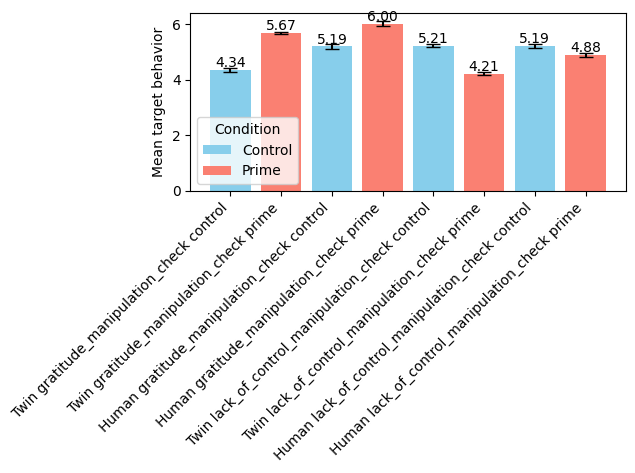

In [13]:
# graph for manipulation checks
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# define your two data‐groups
groups = {
    "Twin": df_twin,
    "Human": df_human,
}

# the two levels
conditions = ["control", "prime"]
# pick two distinct colors for the legend
color_map = {"control": "skyblue", "prime": "salmon"}


# helper to compute SEM
def compute_sem(series):
    series = series.dropna()
    return series.std(ddof=1) / np.sqrt(series.count())


labels = []
means = []
sems = []
colors = []

# First 4 bars: gratitude by cond
for grp_name, df in groups.items():
    for cond in conditions:
        subset = df[df["cond"] == cond]
        labels.append(f"{grp_name} gratitude_manipulation_check {cond}")
        means.append(subset["gratitude_manipulation_check"].mean())
        sems.append(compute_sem(subset["gratitude_manipulation_check"]))
        colors.append(color_map[cond])

# Next 4 bars: lack of control by cond
for grp_name, df in groups.items():
    for cond in conditions:
        subset = df[df["cond"] == cond]
        labels.append(f"{grp_name} lack_of_control_manipulation_check {cond}")
        means.append(subset["lack_of_control_manipulation_check"].mean())
        sems.append(compute_sem(subset["lack_of_control_manipulation_check"]))
        colors.append(color_map[cond])

# Plot
x = np.arange(len(means))
fig, ax = plt.subplots()
bars = ax.bar(x, means, yerr=sems, capsize=5, color=colors)

# Annotate each bar with its mean
for bar, mean in zip(bars, means):
    ax.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{mean:.2f}", ha="center", va="bottom"
    )

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("Mean target behavior")

# Legend for opt‐in vs. opt‐out
legend_handles = [Patch(facecolor=color_map[c], label=c.capitalize()) for c in conditions]
ax.legend(handles=legend_handles, title="Condition")

plt.tight_layout()
plt.show()

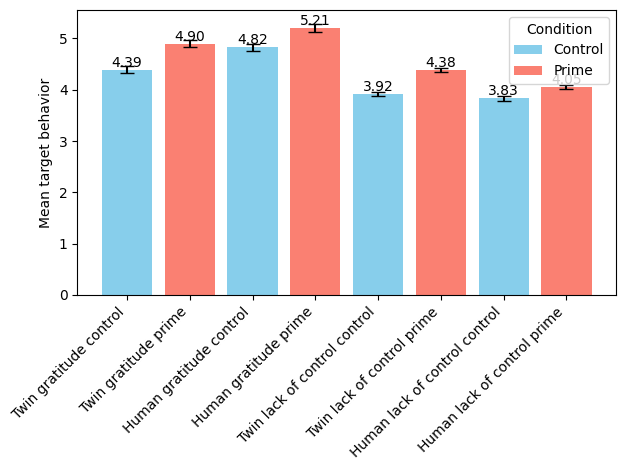

In [11]:
# graph for DVs
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# define your two data‐groups
groups = {
    "Twin": df_twin,
    "Human": df_human,
}

# the two levels
conditions = ["control", "prime"]
# pick two distinct colors for the legend
color_map = {"control": "skyblue", "prime": "salmon"}


# helper to compute SEM
def compute_sem(series):
    series = series.dropna()
    return series.std(ddof=1) / np.sqrt(series.count())


labels = []
means = []
sems = []
colors = []

# First 4 bars: gratitude by cond
for grp_name, df in groups.items():
    for cond in conditions:
        subset = df[df["cond"] == cond]
        labels.append(f"{grp_name} gratitude {cond}")
        means.append(subset["gratitude"].mean())
        sems.append(compute_sem(subset["gratitude"]))
        colors.append(color_map[cond])

# Next 4 bars: lack of control by cond
for grp_name, df in groups.items():
    for cond in conditions:
        subset = df[df["cond"] == cond]
        labels.append(f"{grp_name} lack of control {cond}")
        means.append(subset["lack of control"].mean())
        sems.append(compute_sem(subset["lack of control"]))
        colors.append(color_map[cond])

# Plot
x = np.arange(len(means))
fig, ax = plt.subplots()
bars = ax.bar(x, means, yerr=sems, capsize=5, color=colors)

# Annotate each bar with its mean
for bar, mean in zip(bars, means):
    ax.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{mean:.2f}", ha="center", va="bottom"
    )

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("Mean target behavior")

# Legend for opt‐in vs. opt‐out
legend_handles = [Patch(facecolor=color_map[c], label=c.capitalize()) for c in conditions]
ax.legend(handles=legend_handles, title="Condition")

plt.tight_layout()
plt.show()